In [1]:
import numpy as np
from scipy import optimize as opt
from scipy import linalg as linearalgebra
import matplotlib.pyplot as plt
import math


In [2]:
#------------------------------------------------OPTIMIZATION FUNCTION
def getBestAnswer(timepoint_weights, P_0_target, i):
    #Problem setup
    timeblocks_no = 4
    vars_per_timeblock = 16
    nodecount = 4
    timestep_duration = 4 #duration in hours
    
    # divide voltages by V_b
    v_base = 10000  #V
    # divide powers by S_b
    s_base = 1000   #W
    # divide impedances by Z_b
    z_base = (v_base * v_base)/s_base  #kOhms
    
    #injection schedule for node i at time t (i=1 t=0, i=2 t=0, i=3 t=0, i=1 t=1, i=2 t=1.....), a negative injection is load, positive is generation
    #Slack bus NOT included!!!
    # t1 = 0000 - 0400, t2 = 0400 - 0800, t3 = 0800 - 1200, t4 = 1200 - 1600
    # node 1,2,3 have PV.
    scheduledinjection = np.array([[-2.8], [-2.8], [-2.8], [0.870], [0.870], [0.870], [18], [18], [18], [16.9], [16.9], [16.9]])
    
    hardware_p_min = [-38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4]
    hardware_p_max = [38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4]
    
    F_r = np.diag([1.3509/z_base, 1.17024/z_base, 0.84111/z_base])                      
    F_x = np.diag([1.32349/z_base, 1.14464/z_base, 0.82271/z_base])     
    
    q_constant = np.array([[2],
                           [2],
                           [2]])
    
    #upper/lower bounds in p.u.
    fmax = np.multiply(100,[1,1,1,1,1,1,1,1,1,1,1,1])
    fmin = np.multiply(100,[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
    
    #Start each battery with 50kWh, all have the same hardware settings
    #Slack has no battery constraints, and no battery! These are indexed beginning at node 1
    batt_initial = np.array([[6], [12], [11]])
    batt_min_e = np.array([[2], [10], [4]]) #user set minimum charge state
    batt_max_e = np.array([[12], [12], [22]]) #user set maximum charge state (powerwall is 13.5, user 3 has two powerwall batteries)
    batt_min_p = np.array([[-7.5], [-7.5], [-7.5]]) #40A breaker 240V, at 80% capacity
    batt_max_p = np.array([[7.5], [7.5], [7.5]])
    
    #--------------------------------------------------------
    '''
    Decision Variables Index: [24 energy trades]
    [00 01 02 03 10 11 12 13 20 21 22 23 30 31 32 33]
    
    00 01 02 03
    10 11 12 13
    20 21 22 23
    30 31 32 33
    '''
    #labels for printing output
    decision_variables = ['00','01','02', '03', '10', '11', '12', '13', '20', '21' ,'22', '23', '30', '31', '32', '33']
    timesteps = ['T1','T2','T3','T4']
    
    #we can set individual bounds for any of the decision variables
    bounds = []
    # ---------------------------------- General Variables
    
    
    
    
    
    # ---------------------------------- b part 1: HARDWARE POWER CONSTRAINTS
    # x is a vector of 16*4 variables
    # Incidence matrix so that sum_pij * x(optimization variables) = P_b + P_i
    sum_pij = np.array([[0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1]])
    
    sum_pij_4_timesteps = linearalgebra.block_diag(sum_pij,sum_pij,sum_pij,sum_pij)
    
    # might need to play around with these values
    #hardware_p_min = [-38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4, -38.4]
    #hardware_p_max = [38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4, 38.4]
    
    # all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
    
    constraint_19bp1_min =  {'type':'ineq','fun': lambda x: np.matmul(sum_pij_4_timesteps, x) - hardware_p_min}
    constraint_19bp1_max =  {'type':'ineq','fun': lambda x: hardware_p_max - np.matmul(sum_pij_4_timesteps, x)}
    
    # -----------------------------------b part 2: POWER TRADING CONSTRAINTS
    
    # this is the forcasted amount that we anticipate the node will demand for t=1,2,3,4
    P_nd = np.array([[1],      #t=1 node 1
                     [1],      #t=1 node 2
                     [1],
                     [1],      #t=2
                     [1],
                     [1],
                     [1],      #t=3
                     [1],
                     [1],
                     [1],      #t=4
                     [1],
                     [1]])
    
    # sum_pij_4_timesteps = linearalgebra.block_diag(sum_pij,sum_pij,sum_pij,sum_pij)
    
    # this is the forcasted amount that we anticipate the PV panel will be able to produce for t=1,2,3,4
    P_a_Pv = np.array([[6],     #t=1 node 1
                       [6],     #t=1 node 2
                       [6],
                       [6],     #t=2
                       [6],
                       [6],
                       [6],     #t=3
                       [6], 
                       [6],
                       [6],     #t=4
                       [6],
                       [6]])
    
    P_i_min = -1*P_nd
    
    P_i_max = P_a_Pv - P_nd
    
    constraint_19bp2_min =  {'type':'ineq','fun': lambda x: np.matmul(sum_pij_4_timesteps, x) - np.ndarray.flatten(P_i_min)}
    constraint_19bp2_max =  {'type':'ineq','fun': lambda x: np.ndarray.flatten(P_i_max) - np.matmul(sum_pij_4_timesteps, x)}
    
    # ---------------------------------- c: VOLTAGE CONSTRAINTS
    
    # make R matrix and v bar
    big_Wbar = np.array([[1,-1,0,0],      # 0 -> 1
                         [0,1,-1,0],      # 1 -> 2
                         [0,0,1,-1]])     # 2 -> 3
    
    big_W = np.array([big_Wbar[0][1:],
                      big_Wbar[1][1:],
                      big_Wbar[2][1:]])
    
    little_wbar = np.array([[big_Wbar[0][0]],
                            [big_Wbar[1][0]],
                            [big_Wbar[2][0]]])
    
    big_W_inv = np.linalg.inv(big_W)
    
    big_W_inv_T = np.transpose(big_W_inv)
    
    # values adopted from paper 43 referenced in Ullah and Park. Units in ohms.
    #F_r = np.diag([1.3509/z_base, 1.17024/z_base, 0.84111/z_base])                      
    #F_x = np.diag([1.32349/z_base, 1.14464/z_base, 0.82271/z_base])           
    
    #q_constant = np.array([[2],
                           #[2],
                           #[2]])
    
    # v^2 = (R_matrix * sum_pij * x) + v_bar
    R_matrix = np.matmul(np.matmul(big_W_inv, F_r), big_W_inv_T)                                                                   #3x3
    v_bar = np.matmul(big_W_inv, -1*little_wbar) + np.matmul(np.matmul(np.matmul(big_W_inv, F_x), big_W_inv_T), q_constant)        #3x1
    
    R_matrix_4_timesteps = linearalgebra.block_diag(R_matrix,R_matrix,R_matrix,R_matrix)                                          #12x12
    v_bar_4_timesteps = np.vstack((v_bar,v_bar,v_bar,v_bar))                                                                      #12x1
    
    # upper and lower bounds
    v_max_squared = 1.05*1.05
    v_min_squared = 0.95*0.95
    v_max = np.array([[v_max_squared],[v_max_squared],[v_max_squared],[v_max_squared],[v_max_squared],[v_max_squared],[v_max_squared],[v_max_squared],[v_max_squared],[v_max_squared],[v_max_squared],[v_max_squared]])
    v_min = np.array([[v_min_squared],[v_min_squared],[v_min_squared],[v_min_squared],[v_min_squared],[v_min_squared],[v_min_squared],[v_min_squared],[v_min_squared],[v_min_squared],[v_min_squared],[v_min_squared]])
    
    #                                                                    12x12                           12x64   64x1              12x1                12x1
    constraint_19c_min =  {'type':'ineq','fun': lambda x: np.matmul(R_matrix_4_timesteps,np.matmul(sum_pij_4_timesteps,x)) + np.ndarray.flatten(v_bar_4_timesteps - v_min)}
    constraint_19c_max =  {'type':'ineq','fun': lambda x: np.ndarray.flatten(v_max - v_bar_4_timesteps) - (np.matmul(R_matrix_4_timesteps,np.matmul(sum_pij_4_timesteps,x)))}
    
    
    # ---------------------------------- f: POWER FLOW CONSTRAINTS
    
    #Wbar matrix for 4 node system
    Wbar = [[1,-1,0,0],
            [0,1,-1,0],
            [0,0,1,-1]]
    
    #W matrix for 4 node system
    W = [Wbar[0][1:],
        Wbar[1][1:],
        Wbar[2][1:]]
    
    # linear transform to calculate f (convert energy trades to net nodal power injections at nodes 1->3)
    nodal_power_transform = [[0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1]]
    
    # block diagonalizing Wbar, W, and nodal_power_transform 4 times in order to account for 4 timesteps
    nodal_power_transform_4_timesteps = linearalgebra.block_diag(nodal_power_transform,nodal_power_transform,nodal_power_transform,nodal_power_transform)
    W_inv_T =np.transpose(np.linalg.inv(W))
    W_inv_T_4_timesteps = linearalgebra.block_diag(W_inv_T,W_inv_T,W_inv_T,W_inv_T)
    
    #calculate A matrix for constraint: lb <= Ax <= ub
    f_matrix = np.matmul(W_inv_T_4_timesteps,nodal_power_transform_4_timesteps)
    
    #upper/lower bounds in p.u.
    #fmax = np.multiply(100,[1,1,1,1,1,1,1,1,1,1,1,1])
    #fmin = np.multiply(100,[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
    
    #----------------------------------------------------------------Battery Constraints
    
    # Incidence matrix so that sum_pij * x(optimization variables) = P_b + P_i
    sum_pij = np.array([[0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1]])
    
    sum_pij_4_timesteps = linearalgebra.block_diag(sum_pij,sum_pij,sum_pij,sum_pij)
    
    #Start each battery with 50kWh, all have the same hardware settings
    #Slack has no battery constraints, and no battery! These are indexed beginning at node 1
    #batt_initial = np.array([[6], [12], [11]])
    #batt_min_e = np.array([[2], [10], [4]]) #user set minimum charge state
    #batt_max_e = np.array([[12], [12], [22]]) #user set maximum charge state (powerwall is 13.5, user 3 has two powerwall batteries)
    #batt_min_p = np.array([[-7.5], [-7.5], [-7.5]]) #40A breaker 240V, at 80% capacity
    #batt_max_p = np.array([[7.5], [7.5], [7.5]])
    
    batt_initial_t = np.vstack((batt_initial, batt_initial, batt_initial, batt_initial))
    batt_min_e_t = np.vstack((batt_min_e, batt_min_e, batt_min_e, batt_min_e))
    batt_max_e_t = np.vstack((batt_max_e, batt_max_e, batt_max_e, batt_max_e))
    batt_min_p_t = np.vstack((batt_min_p, batt_min_p, batt_min_p, batt_min_p))
    batt_max_p_t = np.vstack((batt_max_p, batt_max_p, batt_max_p, batt_max_p))
    
    #produces a 12x64, that takes Pijt, and returns Pit (summing over j)
    #excludes any row that sums power injected at the slack, we do not want to include P0 injection in any of the battery constraints. It is unscheduled
    sumj_Pijt = np.zeros(((nodecount - 1) * timeblocks_no, vars_per_timeblock * timeblocks_no))
    for i in range(timeblocks_no):
      for j in range(nodecount-1):
        for k in range(nodecount):
          sumj_Pijt[i * (nodecount-1) + j][vars_per_timeblock * i + (nodecount) * j + k + nodecount] = 1
    
    #produces the matrix that sums all previous power injections into a battery (it is a 3x3 identity that appears in every submatrix below the diagonal in a 12x12)
    #when multiplying sumPijt(x) into this matrix, it produces the energy state at the start of time interval t for battery at node i
    '''
    example with a 2x2 in an 8x8
    0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0 
    0  1  0  0  0  0  0  0
    1  0  1  0  0  0  0  0
    0  1  0  1  0  0  0  0
    1  0  1  0  1  0  0  0
    0  1  0  1  0  1  0  0
    '''
    
    #excludes any injection at the slack! This only looks at the sum of the powers at bus 1, 2, and 3
    energyadded = np.zeros(((nodecount - 1) * timeblocks_no, (nodecount - 1) * timeblocks_no))
    for i in range(timeblocks_no):
      for j in range(nodecount - 1):
        for k in range(nodecount - 1):
          if k < i:
            energyadded[i * (nodecount - 1) + j][k * (nodecount - 1) + j] = 1
    
    #create a matrix that is a 3x12, which will sum the power injected to each battery.
    totalbattpower = np.identity((nodecount - 1))
    totalbattpower = np.hstack((totalbattpower, totalbattpower, totalbattpower, totalbattpower))
    
    #These values are the prosumer bid pricing coefficients for prosumer i
    quadratic_coefficients = [.1, .2, .3, .4]
    linear_coefficients = [5, 6, 7, 8]
    
    #(19e) constraint matrix
    e_constraints_per_time = 10
    e_constraint_mtx = np.zeros((e_constraints_per_time * timeblocks_no, vars_per_timeblock * timeblocks_no))
    
    for i in range(timeblocks_no): #this loop iterates through time blocks
    
      #Trade Balance, power sent = power received from i to j
      e_constraint_mtx[0 + (i * e_constraints_per_time)][1 + (i * vars_per_timeblock)] = 1; # 0 -> 1
      e_constraint_mtx[0 + (i * e_constraints_per_time)][4 + (i * vars_per_timeblock)] = 1; # 1 -> 0
      e_constraint_mtx[1 + (i * e_constraints_per_time)][2 + (i * vars_per_timeblock)] = 1; # 0 -> 2
      e_constraint_mtx[1 + (i * e_constraints_per_time)][8 + (i * vars_per_timeblock)] = 1; # 2 -> 0
      e_constraint_mtx[2 + (i * e_constraints_per_time)][3 + (i * vars_per_timeblock)] = 1; # 0 -> 3
      e_constraint_mtx[2 + (i * e_constraints_per_time)][12 + (i * vars_per_timeblock)] = 1; # 3 -> 0
      e_constraint_mtx[3 + (i * e_constraints_per_time)][6 + (i * vars_per_timeblock)] = 1; # 1 -> 2
      e_constraint_mtx[3 + (i * e_constraints_per_time)][9 + (i * vars_per_timeblock)] = 1; # 2 -> 1
      e_constraint_mtx[4 + (i * e_constraints_per_time)][7 + (i * vars_per_timeblock)] = 1; # 1 -> 3
      e_constraint_mtx[4 + (i * e_constraints_per_time)][13 + (i * vars_per_timeblock)] = 1; # 3 -> 1
      e_constraint_mtx[5 + (i * e_constraints_per_time)][11 + (i * vars_per_timeblock)] = 1; # 2 -> 3
      e_constraint_mtx[5 + (i * e_constraints_per_time)][14 + (i * vars_per_timeblock)] = 1; # 3 -> 2
    
      #Self-trades
      e_constraint_mtx[6 + (i * e_constraints_per_time)][0 + (i * vars_per_timeblock)] = 1; # 0 -> 0
      e_constraint_mtx[7 + (i * e_constraints_per_time)][5 + (i * vars_per_timeblock)] = 1; # 1 -> 1
      e_constraint_mtx[8 + (i * e_constraints_per_time)][10 + (i * vars_per_timeblock)] = 1; # 2 -> 2
      e_constraint_mtx[9 + (i * e_constraints_per_time)][15 + (i * vars_per_timeblock)] = 1; # 3 -> 3
    
    
    # ---------------------------------- CONSTRAINTS
    constraint = (
                  # (19bp1) constraints: Harware Power Constraints
                  constraint_19bp1_min,
                  constraint_19bp1_max,
    
                  # (19bp2) constraints: Max Injection Constraint
                  #constraint_19bp2_min,
                  #constraint_19bp2_max,
        
                  # (19c) constraints: Voltage Constraints
                  constraint_19c_min,
                  constraint_19c_max,
    
          #Something about 19D needs to be reworked, these constraints cause it to fail
                  # (19d) constraints
                  {'type':'ineq','fun': lambda x: fmax - np.matmul(f_matrix,x)},
                  {'type':'ineq','fun': lambda x: np.multiply(-1,fmin) + np.matmul(f_matrix,x)},
    
                  # (19e) constraints
                  {'type':'eq','fun': lambda x: np.matmul(e_constraint_mtx, x)},  #do all at once, timesteps now included
    
                  #Battery Constraints
                  #Power Min
                  {'type':'ineq','fun': lambda x: np.matmul(sumj_Pijt, x) - np.ndarray.flatten(scheduledinjection + batt_min_p_t)},
                  #Power Max
                  {'type':'ineq','fun': lambda x: np.ndarray.flatten(scheduledinjection + batt_max_p_t) - np.matmul(sumj_Pijt, x)},
                  #Charge State Min
                  {'type':'ineq','fun': lambda x: np.ndarray.flatten(batt_initial_t - batt_min_e_t) - (np.matmul(energyadded, np.matmul(sumj_Pijt, x) - np.ndarray.flatten(scheduledinjection)) * timestep_duration)},
                  #Charge State Max
                  {'type':'ineq','fun': lambda x: np.ndarray.flatten(batt_max_e_t - batt_initial_t) + (np.matmul(energyadded, np.matmul(sumj_Pijt, x) - np.ndarray.flatten(scheduledinjection)) * timestep_duration)},
                  #Final Charge State, return to where it started
                  {'type':'eq','fun': lambda x: np.matmul(totalbattpower, (np.matmul(sumj_Pijt, x) - np.ndarray.flatten(scheduledinjection)))},
                  )
    
    # -------------------------------------------- Cost Function 1 ---------------------------------------------------
    
    '''
    #cost function formulation: this can be quadratic or linear
    consumer charge is form ax^2 + bx where a and b are coefficients chosen by the consumer
    To get in the cost function form we will see (x)T*A*x + bx where A a matrix form:
    
    [a1 0   0   0   0   0]
    [0  a1  0   0   0   0]
    [0  0   a1  0   0   0]
    [0  0   0   a2  0   0]
    [0  0   0   0   a2  0]
    [0  0   0   0   0  a2]
    
    and b is a vector [b1 b1 b1 b2 b2 b2]
    
    corresponding to the indices of i. That is, all entries in a and b will be ai and bi for pi
    '''
    
    '''   ------------------unused for now---------------------------
    def cost_function(x, quad_coefficients, lin_coefficients):
    
      Q = np.zeros((vars_per_timeblock * timeblocks_no, vars_per_timeblock * timeblocks_no))
      C = np.zeros((vars_per_timeblock * timeblocks_no))
      for t in range(timeblocks_no):
        for i in range(nodecount):
          for j in range(nodecount):
            indexval = t * (nodecount ** 2) + i * nodecount + j
            Q[indexval][indexval] = quad_coefficients[i]
            C[indexval] = lin_coefficients[i]
    
      #Original general return proposed in the paper. We modify
      ##return np.matmul(np.transpose(x),np.matmul(Q,x)) + np.matmul(C,x)
        return np.matmul(np.ones(64), np.maximum(np.zeros(64), x)) #doesn't use the quadratic terms, this is a work in progress
    '''
    
    # -------------------------------------------- END Cost Function 1 ---------------------------------------------------
    
    #set initial guess for every prosumer to get all their power from the grid
    initial_guess = np.tile(np.zeros(vars_per_timeblock),timeblocks_no)
    for i in range(timeblocks_no):
      for j in range(nodecount-1):
        initial_guess[(j + 1)+(i*vars_per_timeblock)] = scheduledinjection[j + (i * (nodecount - 1))][0] * -1
        initial_guess[((j+1) * nodecount)+(i*vars_per_timeblock)] = scheduledinjection[j+ (i * (nodecount - 1))][0]
    
    # ---------------------------------------------------------------------- Cost Function 2
    # Kelsey's Version of Cost Function (Incentivizes sending some predetermined amount to slack bus)
    
    # Set negative target injection that slack bus would like to achieve (the target power that slack wants to receive)
    #P_0_target = np.array([[12],
                           #[1], 
                           #[1], 
                           #[12]])
    
    #timepoint_weights = np.array([[10], [2], [3], [1]])
    
    #----------------------------------------------------- COST FUNCTION -----------------------------------------------
    # actual cost function
    def cost_function(x, P_0_target, timepoint_weights, resistance_matrix, vbar):
    
      #Kelsey's P0 Target Injection
      # setting up structure/variables for cost function
      sum_Pi0 = np.array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
      sum_Pi0t = linearalgebra.block_diag(sum_Pi0, sum_Pi0, sum_Pi0, sum_Pi0)
    
      sumPij = linearalgebra.block_diag(np.ones(4), np.ones(4), np.ones(4))
      sumPij = np.hstack((np.zeros((3, 4)), sumPij))
      sumPijt = linearalgebra.block_diag(sumPij, sumPij, sumPij, sumPij)
    
      weights_diag = np.diag(np.ndarray.flatten(timepoint_weights))
    
      #Kelsey's Grid Operator Power Targets
      P0_weighted_targetdiff = np.matmul(weights_diag, np.matmul(sum_Pi0t, x) - np.ndarray.flatten(P_0_target))
      P0_target_penalty = (np.matmul(np.transpose(P0_weighted_targetdiff), P0_weighted_targetdiff))
    
      #Ryan's voltage losses
      node_voltages = np.matmul(resistance_matrix, np.matmul(sum_pij_4_timesteps, x)) + np.ndarray.flatten(vbar)
    
      #Ryan's middleman restriction
      #Sums all the outgoing (positive) trades. This is convex because max is convex. If there is a middleman trade, the outgoing trade from origin to destination is duplicated as a middleman outgoing
      #squared to make the function differentiable at every point, easier for the optimizer
      middleman_penalty = ((np.matmul(np.ones(64), np.maximum(np.zeros(64), x))) ** 2) * 0.01
      return middleman_penalty + P0_target_penalty 
    
    #---------------------------------------------------------Initial Guess
    #set initial guess for every prosumer to get all their power from the grid
    initial_guess = np.tile(np.zeros(vars_per_timeblock),timeblocks_no)
    for i in range(timeblocks_no):
      for j in range(nodecount-1):
        initial_guess[(j + 1)+(i*vars_per_timeblock)] = scheduledinjection[j + (i * (nodecount - 1))][0] * -1
        initial_guess[((j+1) * nodecount)+(i*vars_per_timeblock)] = scheduledinjection[j+ (i * (nodecount - 1))][0]
    
    #print("Initial Guess: ", initial_guess)
    #print(" ")
    
    #----------------------------------------------------------Optimization Problem Results
    
    # return results of optimization problem
    results = opt.minimize(fun=cost_function,args=(P_0_target, timepoint_weights, R_matrix_4_timesteps, v_bar_4_timesteps),x0=initial_guess,constraints=constraint, options={"maxiter": 100, "ftol": 1e-5, "disp":True}) #can add method="method"
    
    #Status:
      #0 = optimal solution found
      #1 = iteration limit reached
      #2 = infeasible
      #3 = unbounded
      #6 = ill-conditioned matrix
      #8 = did not converge in iteration limit
      #9 = failed, can't make further progress
    #print("Optimization Status: ", results.status)
    #print(" ")
    
    #round all values to a specific decimal precision
    decimal_precision = 2
    for i in range(64):
      # Values that will display as -0.0 are rounded to zero
      if results.x[i] <= 0 and results.x[i] >= -1*(0.1**(decimal_precision)):
        results.x[i] = 0
      results.x[i] = round(results.x[i],decimal_precision)
    
    # printing the output
    #for i in range(64):
      #print(timesteps[i // 16],'--', decision_variables[i % 16],':  ', results.x[i], 'per unit')
    
    
    #unsure what this is, but had to move it down below the solver
    #transform =           [[0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0],
                            #[0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0],
                            #[0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1]]
    
    #fourTransform = linearalgebra.block_diag(transform,transform,transform,transform)
    
    #print(np.matmul(fourTransform,np.round(results.x,4))-np.transpose(scheduledinjection.flatten()))
    
    # ----------------------------------------------------- Recovering P_injected_battery = Sum_P_ij - P_scheduled_inj
    
    # This block of code sums all trades from a particular node to all other nodes at timestep t into an array structure like below.
    # ts = 0, from node 0 | ts = 1, from node 1 | ts = 1, from node 2 | ts = 1, from node 3 | 
    # ts = 1, from node 0 | ts = 2, from node 1 | ts = 2, from node 2 | ts = 2, from node 3 | 
    # ts = 2, from node 0 | ts = 3, from node 1 | ts = 3, from node 2 | ts = 3, from node 3 |
    # ts = 3, from node 0 | ts = 4, from node 1 | ts = 4, from node 2 | ts = 4, from node 3 | 
    
    idx = 0
    
    # sum_pij_array is a 4x4 array which stores the sum_pij
    sum_pij_array = np.zeros((4,4))
    for timestep in range(0, 4):
      #print("timestep:", timestep)
      for n in range(0,4):
        #print("node:", n)
        for trade in range(0,4):
                #print("trade:", trade)
                # sum each trade into the array[timestep][node]
                #print("adding ", np.round(results.x[idx],2))
          sum_pij_array[timestep,n] = sum_pij_array[timestep,n] + np.round(results.x[idx], 2)
                
                #print("_______________________")
                #print("|", sum_pij_array[0,0],"|",sum_pij_array[0,1],"|",sum_pij_array[0,2],"|",sum_pij_array[0,3],"|")
                #print("|", sum_pij_array[1,0],"|",sum_pij_array[1,1],"|",sum_pij_array[1,2],"|",sum_pij_array[1,3],"|")
                #print("|", sum_pij_array[2,0],"|",sum_pij_array[2,1],"|",sum_pij_array[2,2],"|",sum_pij_array[2,3],"|")
                #print("|", sum_pij_array[3,0],"|",sum_pij_array[3,1],"|",sum_pij_array[3,2],"|",sum_pij_array[3,3],"|")
                #print("_______________________")
    
          idx = idx + 1
        
    # display constraint P_i_t_max or P_i_t_min.
    #print("constraints constraint_19bp2_min, constraint_19bp2_max are off")
    #print(P_i_min)
    #print(" ")
    #print(P_i_max)
    #print(" ")
        
    # display amount requested by slack bus 
    print("slack bus is requesting")
    print(P_0_target)
    print(" ")
        
    # negative number means consumed, positive number means injected
    print("sum_pij (horizontal axis is node, vertical axis is timestep) Negative number means consumed, positive means injected")
    print(sum_pij_array)
    print(" ")
        
    #injection schedule for node i at time t (i=1 t=0, i=2 t=0, i=3 t=0, i=1 t=1, i=2 t=1.....), a negative injection is load, positive is generation. Slack bus NOT included!!!
    #put the provided scheduleinjection vector into an array of the same shape of "sum_pij_array" (which holds sum of Pij) 
    p_ij_initial  = np.concatenate((np.zeros((4,1)), np.reshape(scheduledinjection, (4,3))), axis = 1)
    print("scheduledinjection variable is at time t")
    print(p_ij_initial)
    print(" ")
        
    # let b_p be sum_pij_array - p_ij_initial 
    b_p = sum_pij_array - p_ij_initial
    print("b_p = sum_pij_array - p_ij_initial  (negative means additional pwr added to battery)")
    print(b_p)
    print(" ")

    # ------------------------------------ RYAN BATTERY STATE --------------------------------------------
    tradesum_arr = linearalgebra.block_diag(np.ones(4),np.ones(4),np.ones(4),np.ones(4))
    tradesum_arr_t = linearalgebra.block_diag(tradesum_arr, tradesum_arr, tradesum_arr, tradesum_arr)
            
    #Trade Sum
    tradesum = np.matmul(tradesum_arr_t, results.x)
            
    #power battery injects to node
    battery_power = np.matmul(sumj_Pijt, results.x) - np.ndarray.flatten(scheduledinjection)
        
    #battery state at the START of each timestep
    battery_state = np.ndarray.flatten(batt_initial_t) - (np.matmul(energyadded, np.matmul(sumj_Pijt, results.x) - np.ndarray.flatten(scheduledinjection)) * timestep_duration)
    battery_state_reshaped = np.reshape(battery_state, (4,3))
            
    #Voltage at nodes
    node_voltage = np.sqrt(np.matmul(R_matrix_4_timesteps,np.matmul(sum_pij_4_timesteps,results.x)) + np.ndarray.flatten(v_bar_4_timesteps))

    print("Battery State BEFORE timestep: \n", battery_state_reshaped)
    print("Battery Power:                \n ", np.reshape(battery_power, (4,3)))
    print("Power Injected at all nodes: \n ", np.reshape(tradesum, (4,4)))
    #print("Node Voltages: \n", np.reshape(node_voltage, (4,3)))

    
    ''' ---------------------------unused, but may be useful if voltage differences needed ---------------------
    v1_mtx = linearalgebra.block_diag(np.ones((4,1)),np.ones((4,1)), np.ones((4,1)),np.ones((4,1)))
    v2_mtx = np.vstack((np.identity(4),np.identity(4), np.identity(4), np.identity(4)))
    diff_mtx = v1_mtx - v2_mtx
    onearray = np.array([1])
    
    all_node_voltage = np.concatenate((onearray, node_voltage[0:3], onearray, node_voltage[3:6], onearray, node_voltage[6:9], onearray, node_voltage[9:12]))
    
    voltage_diff_mtx = linearalgebra.block_diag(diff_mtx, diff_mtx, diff_mtx, diff_mtx)
    
    #Gives a vector indexed the same way as the power trades, with all the voltage differences between node a and node b at time t
    all_node_voltage_diff = np.matmul(voltage_diff_mtx, all_node_voltage)
    
    #unused here
    all_node_voltage_diff_squared = np.matmul(np.diag(all_node_voltage_diff), all_node_voltage_diff)
    ---------------------------------------------------------------------------------------------'''
    
    # Print picture
    # Example code copied from below and modified to fit our use case
    # https://seaborn.pydata.org/examples/spreadsheet_heatmap.html
    #import matplotlib.pyplot as plt
    #import seaborn as sns
    #import pandas as pd
    #df2 = pd.DataFrame(sum_pij_array,
     #                  columns=['slack bus', 'node 1', 'node 2', 'node 3'],
     #                  index=['t = 1', 't = 2', 't = 3', 't = 4'])
    
    # Draw a heatmap with the numeric values in each cell
    #f, ax = plt.subplots(figsize=(5, 4))
    #sns.heatmap(df2, annot=True, linewidths=.5, ax=ax)
    

    return battery_state_reshaped

In [258]:
#------------------------------------------------VARIABLES THAT ARE OFTEN CHANGED
# weights for cost function
timepoint_weights = np.array([[1], [1], [1], [1]])

start = 100
stop = 100
length = start+stop+1

# for cost function
P_0_target = np.array([[0],
                       [0], 
                       [0], 
                       [0]])

#node one
batt_res_n1s = np.zeros((1,length))
batt_res_n1at1 = np.zeros((1,length))
batt_res_n1at2 = np.zeros((1,length))
batt_res_n1at3 = np.zeros((1,length))

#node two
batt_res_n2s = np.zeros((1,length))
batt_res_n2at1 = np.zeros((1,length))
batt_res_n2at2 = np.zeros((1,length))
batt_res_n2at3 = np.zeros((1,length))

#node three
batt_res_n3s = np.zeros((1,length))
batt_res_n3at1 = np.zeros((1,length))
batt_res_n3at2 = np.zeros((1,length))
batt_res_n3at3 = np.zeros((1,length))


for i in range(-1*start,stop+1):
    print('-------------------------------------------------------------------------',i)
    P_0_target[2,:] = i
    battery_state_array = getBestAnswer(timepoint_weights, P_0_target, i)

    #node one
    batt_res_n1s[0,start+i] = battery_state_array[0,0]
    batt_res_n1at1[0,start+i] = battery_state_array[1,0]
    batt_res_n1at2[0,start+i] = battery_state_array[2,0]
    batt_res_n1at3[0,start+i] = battery_state_array[3,0]
    
    #node two
    batt_res_n2s[0,start+i] = battery_state_array[0,1]
    batt_res_n2at1[0,start+i] = battery_state_array[1,1]
    batt_res_n2at2[0,start+i] = battery_state_array[2,1]
    batt_res_n2at3[0,start+i] = battery_state_array[3,1]
    
    #node three
    batt_res_n3s[0,start+i] = battery_state_array[0,2]
    batt_res_n3at1[0,start+i] = battery_state_array[1,2]
    batt_res_n3at2[0,start+i] = battery_state_array[2,2]
    batt_res_n3at3[0,start+i] = battery_state_array[3,2]
    

------------------------------------------------------------------------- -100
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17614.352131111194
            Iterations: 48
            Function evaluations: 3204
            Gradient evaluations: 48
slack bus is requesting
[[   0]
 [   0]
 [-100]
 [   0]]
 
sum_pij (horizontal axis is node, vertical axis is timestep) Negative number means consumed, positive means injected
[[ 11.75  -4.    -4.5   -3.25]
 [-10.2    3.4    3.4    3.4 ]
 [-28.5    9.5   11.5    7.5 ]
 [-28.25   9.5    8.    10.75]]
 
scheduledinjection variable is at time t
[[ 0.  -5.  -5.  -5. ]
 [ 0.   3.4  3.4  3.4]
 [ 0.  12.  12.  12. ]
 [ 0.   8.   8.   8. ]]
 
b_p = sum_pij_array - p_ij_initial  (negative means additional pwr added to battery)
[[ 11.75   1.     0.5    1.75]
 [-10.2    0.     0.     0.  ]
 [-28.5   -2.5   -0.5   -4.5 ]
 [-28.25   1.5    0.     2.75]]
 
Battery State BEFORE timestep: 
 [[ 6. 12. 11.]
 [ 2. 10. 

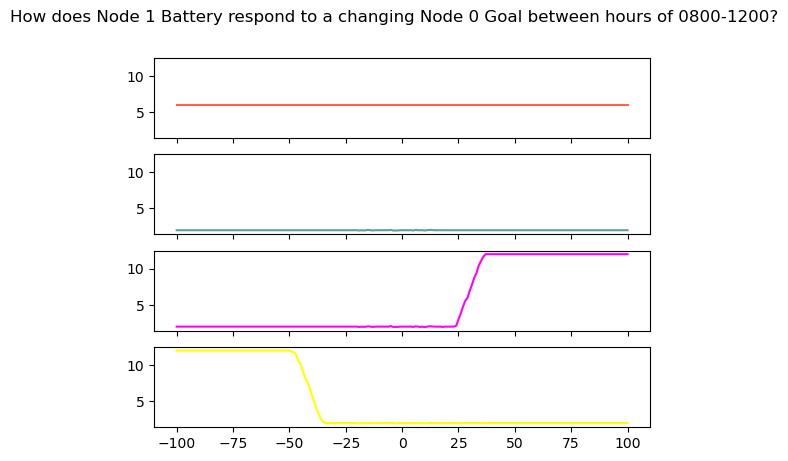

In [266]:
# used example below to help plotting multiple lines on a single plot
# https://www.geeksforgeeks.org/plot-multiple-plots-in-matplotlib/
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html

# create the x values
node_zero_req_value = np.linspace(-1*start, stop, length)    #(length,)

# get the values you want to plot in a nice format
batt_res_n1s_r = np.ndarray.flatten(batt_res_n1s)
batt_res_n1at1_r = np.ndarray.flatten(batt_res_n1at1)
batt_res_n1at2_r = np.ndarray.flatten(batt_res_n1at2)
batt_res_n1at3_r = np.ndarray.flatten(batt_res_n1at3)

fig,axs = plt.subplots(4, sharex=True, sharey=True)
#fig.suptitle('Effect of Modifying Node 0 Demand between hrs 0800-1200 on Node 1 Battery')
fig.suptitle('How does Node 1 Battery respond to a changing Node 0 Goal between hours of 0800-1200?')

# plot all the lines on the same graph
axs[0].plot(node_zero_req_value, batt_res_n1s_r, color = 'tomato', label='starting')
axs[1].plot(node_zero_req_value, batt_res_n1at1_r, color = 'cadetblue', label='after t=1')
axs[2].plot(node_zero_req_value, batt_res_n1at2_r, color = 'fuchsia', label='after t=2')
axs[3].plot(node_zero_req_value, batt_res_n1at3_r, color = 'yellow', label='after t=3')

plt.show()

In [5]:
#------------------------------------------------VARIABLES THAT ARE OFTEN CHANGED
# weights for cost function
timepoint_weights = np.array([[1], [1], [1], [1]])

start = 100
stop = 100
length = start+stop+1

# for cost function
P_0_target = np.array([[5],
                       [-2], 
                       [-50], 
                       [-50]])

#node one
batt_res_n1s = np.zeros((1,length))
batt_res_n1at1 = np.zeros((1,length))
batt_res_n1at2 = np.zeros((1,length))
batt_res_n1at3 = np.zeros((1,length))

#node two
batt_res_n2s = np.zeros((1,length))
batt_res_n2at1 = np.zeros((1,length))
batt_res_n2at2 = np.zeros((1,length))
batt_res_n2at3 = np.zeros((1,length))

#node three
batt_res_n3s = np.zeros((1,length))
batt_res_n3at1 = np.zeros((1,length))
batt_res_n3at2 = np.zeros((1,length))
batt_res_n3at3 = np.zeros((1,length))


for i in range(-1*start,stop+1):
    print('-------------------------------------------------------------------------',i)
    P_0_target[2,:] = i
    battery_state_array = getBestAnswer(timepoint_weights, P_0_target, i)

    #node one
    batt_res_n1s[0,start+i] = battery_state_array[0,0]
    batt_res_n1at1[0,start+i] = battery_state_array[1,0]
    batt_res_n1at2[0,start+i] = battery_state_array[2,0]
    batt_res_n1at3[0,start+i] = battery_state_array[3,0]
    
    #node two
    batt_res_n2s[0,start+i] = battery_state_array[0,1]
    batt_res_n2at1[0,start+i] = battery_state_array[1,1]
    batt_res_n2at2[0,start+i] = battery_state_array[2,1]
    batt_res_n2at3[0,start+i] = battery_state_array[3,1]
    
    #node three
    batt_res_n3s[0,start+i] = battery_state_array[0,2]
    batt_res_n3at1[0,start+i] = battery_state_array[1,2]
    batt_res_n3at2[0,start+i] = battery_state_array[2,2]
    batt_res_n3at3[0,start+i] = battery_state_array[3,2]
    

------------------------------------------------------------------------- -100
Optimization terminated successfully    (Exit mode 0)
            Current function value: 32720.29545465776
            Iterations: 46
            Function evaluations: 3080
            Gradient evaluations: 46
slack bus is requesting
[[   5]
 [  -2]
 [-100]
 [ -50]]
 
sum_pij (horizontal axis is node, vertical axis is timestep) Negative number means consumed, positive means injected
[[  5.15  -1.8   -2.3   -1.05]
 [ -2.61   0.87   0.87   0.87]
 [-46.5   15.5   17.5   13.5 ]
 [-54.95  18.4   16.9   19.65]]
 
scheduledinjection variable is at time t
[[ 0.   -2.8  -2.8  -2.8 ]
 [ 0.    0.87  0.87  0.87]
 [ 0.   18.   18.   18.  ]
 [ 0.   16.9  16.9  16.9 ]]
 
b_p = sum_pij_array - p_ij_initial  (negative means additional pwr added to battery)
[[  5.15   1.     0.5    1.75]
 [ -2.61   0.     0.     0.  ]
 [-46.5   -2.5   -0.5   -4.5 ]
 [-54.95   1.5    0.     2.75]]
 
Battery State BEFORE timestep: 
 [[ 6. 12. 

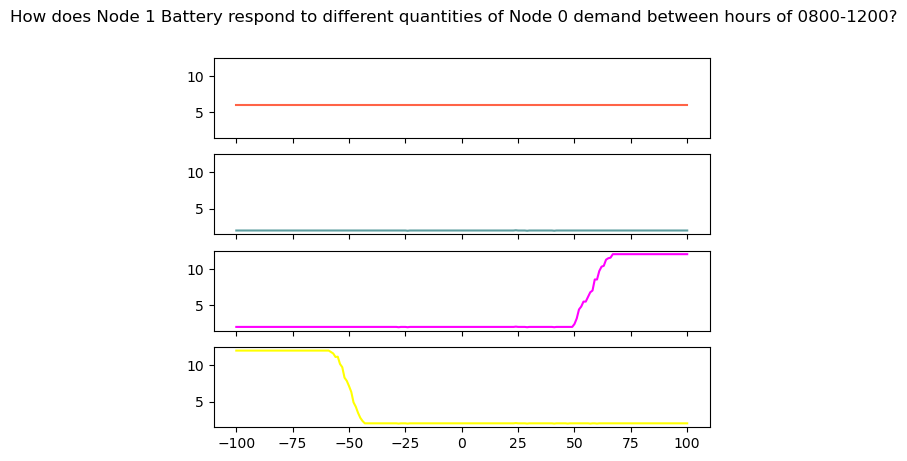

In [7]:
# used example below to help plotting multiple lines on a single plot
# https://www.geeksforgeeks.org/plot-multiple-plots-in-matplotlib/
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html

# create the x values
node_zero_req_value = np.linspace(-1*start, stop, length)    #(length,)

# get the values you want to plot in a nice format
batt_res_n1s_r = np.ndarray.flatten(batt_res_n1s)
batt_res_n1at1_r = np.ndarray.flatten(batt_res_n1at1)
batt_res_n1at2_r = np.ndarray.flatten(batt_res_n1at2)
batt_res_n1at3_r = np.ndarray.flatten(batt_res_n1at3)

fig,axs = plt.subplots(4, sharex=True, sharey=True)
#fig.suptitle('Effect of Modifying Node 0 Demand between hrs 0800-1200 on Node 1 Battery')
fig.suptitle('How does Node 1 Battery respond to different quantities of Node 0 demand between hours of 0800-1200?')

# plot all the lines on the same graph
axs[0].plot(node_zero_req_value, batt_res_n1s_r, color = 'tomato', label='starting')
axs[1].plot(node_zero_req_value, batt_res_n1at1_r, color = 'cadetblue', label='after t=1')
axs[2].plot(node_zero_req_value, batt_res_n1at2_r, color = 'fuchsia', label='after t=2')
axs[3].plot(node_zero_req_value, batt_res_n1at3_r, color = 'yellow', label='after t=3')

plt.show()